In [1]:
import sys; sys.path.append('..')
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from cifar10_models.clip_models import ClipViTB32
from src.data_utils import get_dataset, cifar10_label_names
from src.simple_utils import load_pickle
from os.path import join as pjoin
from collections import Counter

In [2]:
%%capture
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_dir = "/n/holystore01/LABS/barak_lab/Everyone/utils"
checkpoint_dir = "checkpoints13084"
checkpoint_name = "last.ckpt"
path = pjoin(model_dir, checkpoint_dir, checkpoint_name)

checkpoint = torch.load(path)
state_dict = checkpoint['state_dict']
state_dict = {k.split('.', 1)[1]: v for k, v in state_dict.items()}

model = ClipViTB32()
model.load_state_dict(state_dict)
model.to(device)
model.eval()

In [3]:
work_dir = "/n/holystore01/LABS/barak_lab/Lab/nghosh"
data_dir = "data"
dname = "CIFAR5m"

print("loading dataset")
dataset = get_dataset(pjoin(work_dir, data_dir), dset=dname, transform=model.preprocess)
print("done")

loading dataset
reading cifar 5m data from /n/holystore01/LABS/barak_lab/Everyone/cifar-5m
reading class 0
reading class 1
reading class 2
reading class 3
reading class 4
reading class 5
reading class 6
reading class 7
reading class 8
reading class 9
done


In [5]:
pred_dir = "cifar5m"
proc_dir = "processed"
score_dir = "scores"

num_classes = 10

score_types = ["MaxDiffScore", "AreaScore"]
score_type = score_types[0]

score_path = pjoin(work_dir, proc_dir, score_dir, pred_dir + "_" + score_type + ".pkl")
print(score_path)

scores = load_pickle(score_path)
grouped = load_pickle(pjoin(work_dir, proc_dir, f'{pred_dir}.pkl'))

/n/holystore01/LABS/barak_lab/Lab/nghosh/processed/scores/cifar5m_MaxDiffScore.pkl


In [7]:
n = 200000
idx_full = scores[dname]["idx"]
idx_n = idx_full[:n]

In [8]:
dataloader = DataLoader(Subset(dataset, idx_n), batch_size=512, shuffle=False)

In [9]:
acc = []

for i, batch in enumerate(dataloader):
    if i % 100 ==  0:
        print(f'batch_idx: {i}')
        
    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)
    
    with torch.no_grad():
        logits = model(imgs)
        preds = torch.argmax(logits, dim=1)
        acc.append((preds == labels))
        
acc = torch.cat(acc)
acc = acc.cpu().numpy()

idx: 0
idx: 100
idx: 200
idx: 300


In [12]:
idx_acc = idx_n[acc]
print(len(idx_acc))

115713


In [13]:
# plot group plotting symbols
fmts = {
    "Resnet18": "bo",
    "Densenet121": "ro",
    "Resnet18-pretrained": "c^",
    "Densenet121-pretrained": "m^",
    "ClipViTB32": "go",
}

alpha = 0.5
markersize = 12

train_set = "CIFAR10_train"
valid_set = "CIFAR10_test"

gname = 'Resnet18'
points = grouped[dname][gname]['points']

In [48]:
def plot(idx, title=""):    
    subset = points[idx, :]
    subset_mean = np.mean(subset, axis=0)
    subset_mean.shape

    plt.figure(figsize=(8, 6))
    for plot_group in grouped[dname]:
            dct = grouped[dname][plot_group]

            x = dct["x"]
            plt.plot(x, subset_mean, fmts[plot_group], alpha=alpha, markersize=markersize, label=plot_group)

    plt.xlabel("Acc. on %s" % valid_set, fontsize=16)
    plt.ylabel("Acc. on %s Subset %d" % (score_type, len(idx)), fontsize=16)
    plt.ylim(0, 1)
    if len(title) > 0:
        acc_max = np.round(np.max(subset_mean), 3)
        acc_min = np.round(np.min(subset_mean), 3)
        drop = np.round(np.max(subset_mean) - np.min(subset_mean), 3)
        plt.title(title + f', max: {acc_max}, min: {acc_min}, drop: {drop}')
    plt.legend(loc="lower right")
    plt.show()

In [15]:
def min_class_size(idx):
    classes = dataset.data_y[idx]
    
    cnt = Counter(classes)
    for c, val in cnt.most_common():
        print(f"{class_lists[dname][c]}: {100 * val / len(idx):,.2f}%")
    
    min_class = np.inf

    for c in range(num_classes):
        if c not in cnt:
            return 0
        
        min_class = min(min_class, cnt[c])
    
    return min_class
    

In [16]:
def extract_class_bal_dset(idx, min_class):
    class_idxs = []
    classes = dataset.data_y[idx]

    for k in range(num_classes):
        class_idx = np.where(classes == k)[0]
        class_idxs.append(idx[class_idx[:min_class]])

    idx_bal = np.concatenate(class_idxs)
    return idx_bal
    

In [17]:
n_new = 10000

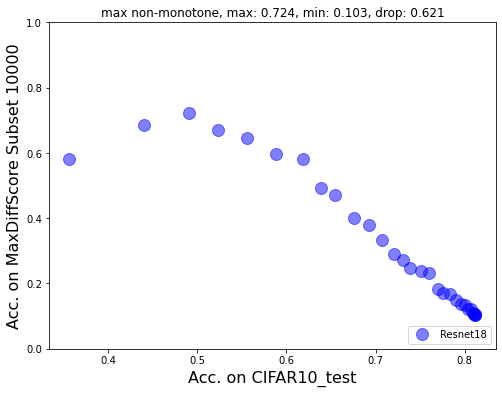

In [49]:
plot(idx_n[:n_new], title="max non-monotone")

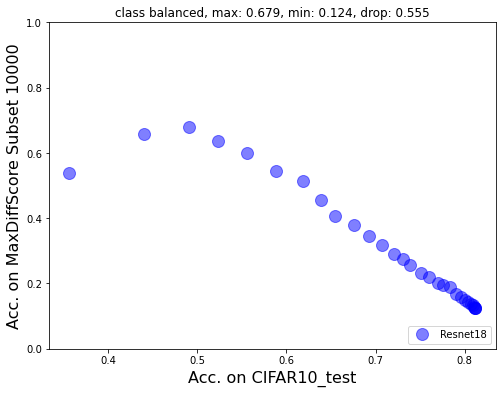

In [50]:
idx_bal = extract_class_bal_dset(idx_n, n_new // num_classes)
plot(idx_bal, title="class balanced")

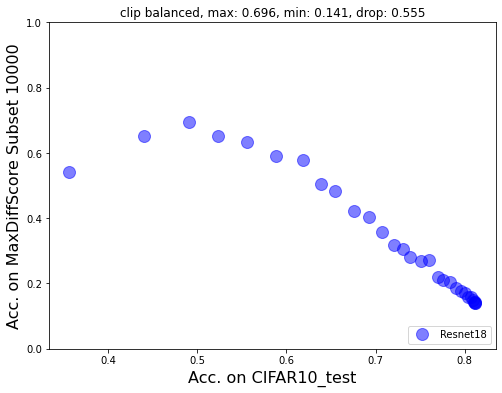

In [51]:
plot(idx_acc[:n_new], title="clip balanced")

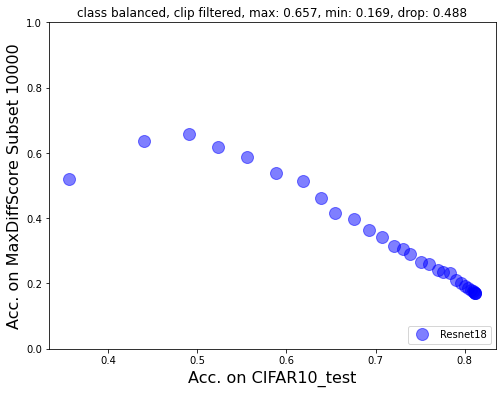

In [52]:
idx_acc_bal = extract_class_bal_dset(idx_acc, n_new // num_classes)
plot(idx_acc_bal, title="class balanced, clip filtered")
